In [1]:
import numpy as np
from scipy import linalg as LA
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def check_dims(m, shape):
    assert type(m) == np.ndarray, "input is not an array"
    assert m.shape == shape, "input shape {} does not match {}".format(m.shape, shape)

In [3]:
def show_data(x, y):
    plt.plot(x, y, "b.")
    plt.show()

## Helper Functions

In [4]:
def get_gaussian_kernel(x, gamma):
    N = x.shape[0]
    K = np.zeros((N, N))
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K[i, j] = np.exp(- (x[i] - x[j])**2 / gamma**2)
    return K

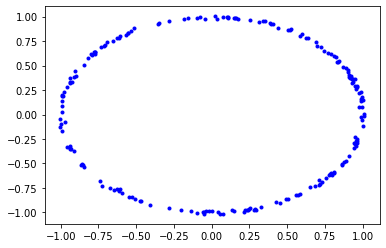

In [5]:
N = 200
t = np.random.uniform(0, 2 * np.pi, size=(N, 1))
n1 = np.random.normal(0, 0.01, (N, 1))
n2 = np.random.normal(0, 0.01, (N, 1))
x = np.sin(t) + n1 # (N, 1)
y = np.cos(t) + n2 # (N, 1)
show_data(x, y)
gamma = 1
eta = 1e-8

0.1451572940441955
X on FX


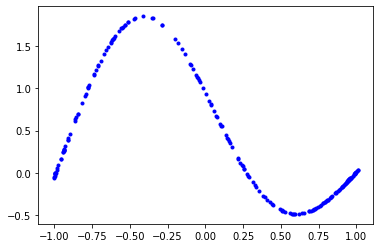

X on FX


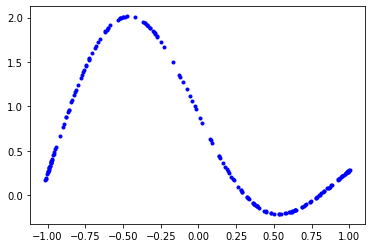

fx on gy


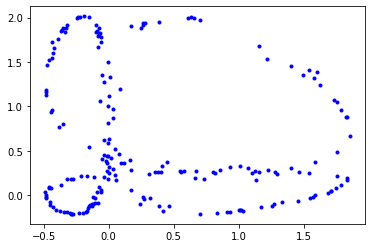

COCO 0.1451572940441955


In [9]:
def incomplete_cholesky_decomposition(K, eta):
    l = K.shape[0]
    j = 0
    R = np.zeros((l, l))
    d = K.diagonal().copy()
    # [a,I(j+1)] = max(d); == selVals, colAssignment = A.max(axis=1), A.argmax(axis=1)
    a, I_jplus1 = d.max(), d.argmax()
    I = [I_jplus1]
    nu = []
    while a > eta:
        nu.append(np.sqrt(a))
        for i in range(l):
            R[i, j] = 1/nu[j] * (K[i, I[j]] - R[:, i].T @ R[:, I[j]])
            d[i] = d[i] - R[i, j] ** 2
        a, I_jplus1 = d.max(), d.argmax()
        I += [I_jplus1]
        j += 1
    T = j
    R = R[:, 0:T]
    return R

def incomplete_cholesky_decomposition(K, eta):
    l = K.shape[0]
    j = 0
    R = np.zeros((l, l))
    d = K.diagonal().copy()
    # [a,I(j+1)] = max(d); == selVals, colAssignment = A.max(axis=1), A.argmax(axis=1)
    a, I_jplus1 = d.max(), d.argmax()
    I = [I_jplus1]
    nu = []
    while a > eta:
        nu.append(np.sqrt(a))
        for i in range(l):
            R[i, j] = 1/nu[j] * (K[i, I[j]] - R[:, i].T @ R[:, I[j]])
            d[i] = d[i] - R[i, j] ** 2
        a, I_jplus1 = d.max(), d.argmax()
        I += [I_jplus1]
        j += 1
    T = j
    R = R[:, 0:T]
    return R

def get_efficient_COCO(x, y, gamma, eta):
    N = x.shape[0]
    
    K = get_gaussian_kernel(x, gamma) # (N, N)
    L = get_gaussian_kernel(y, gamma) # (N, N)
    H = np.eye(N) - np.ones(N) / N
    Ktilde = H @ K @ H # (N, N)
    Ltilde = H @ L @ H # (N, N)
    Z = np.zeros((N, N))

    A = np.block([
        [Z, (1/N * Ktilde @ Ltilde)],
        [(1/N * Ltilde @ Ktilde), Z]
    ])

    B = np.block([
        [Ktilde, Z],
        [Z, Ltilde]
    ]) + (np.eye(2 * N) * 1e-8)

    R = incomplete_cholesky_decomposition(B, eta)
    At = LA.pinv(R) @ A @ LA.pinv(R.T)
    [D, V] = LA.eigh(At)
    coco = np.abs(np.real(D.max()))
    print(coco)
    e1 = LA.pinv(R.T) @ V[:, 0]
    alpha = e1[0:N]
    beta = e1[N:(2*N)]
    fx = K @ H @ alpha
    gy = L @ H @ beta

    print("X on FX")
    show_data(x, fx)
    print("X on FX")
    show_data(y, gy)
    print("fx on gy")
    show_data(fx, gy)
    print("COCO", coco)
#     print(alphaKLbeta / alphaKKalpha betaLLbeta)
get_efficient_COCO(x, y, gamma, eta)

X on F_CX


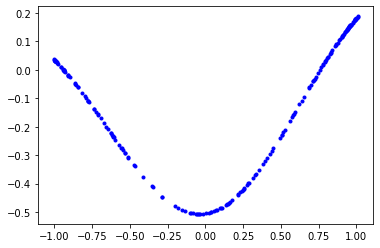

X on F_CX


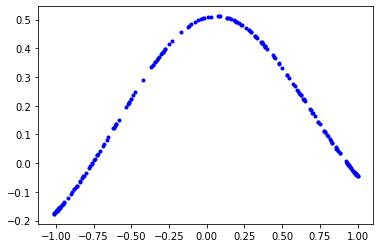

fcx on gcx


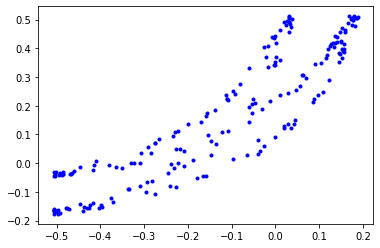

COCO 0.09276501798753248


In [7]:
def get_exact_COCO(x, y, gamma, eta):
    N = x.shape[0]
    
    K = get_gaussian_kernel(x, gamma) # (N, N)
    L = get_gaussian_kernel(y, gamma) # (N, N)
    H = np.eye(N) - np.ones(N) / N
    Ktilde = H @ K @ H # (N, N)
    Ltilde = H @ L @ H # (N, N)
    Z = np.zeros((N, N))

    A = np.block([
        [Z, (1/N * Ktilde @ Ltilde)],
        [(1/N * Ltilde @ Ktilde), Z]
    ])

    B = np.block([
        [Ktilde, Z],
        [Z, Ltilde]
    ]) + (np.eye(2 * N) * 1e-8)
    
    D,V = LA.eigh(A, B, eigvals_only=False)
    max_evi= D.argmax()
    e1 = V[:, max_evi]
    # print(np.real(Dc))
    coco = np.real(D).max()
    beta = e1[N:(2*N)]
    # print((ec1[0:N] @ Ktilde @ Ltilde).shape, betac.shape)
    alpha = e1[0:N] #@ Ktilde @ Ltilde @ betac.T
    # print(alphac.shape, betac.shape)

    fx = K @ H @ alpha
    gx = L @ H @ beta

#     print(alpha.T @ Ktilde @ alpha)
#     print(beta.T @ Ltilde @ beta)

    print("X on F_CX")
    show_data(x, fx)
    print("X on F_CX")
    show_data(y, gx)
    print("fg on gy")
    show_data(fx, gx)
    print("COCO", coco)
get_exact_COCO(x, y, gamma, eta)